In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


#Imports
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# own utils
from utils.graph_utils import *


# Data


- provide data in the form of a pandas dataframe, if there are iamges add the paths to each image to the df

Setting Seed: 42
         x1        x2        x3
0  0.799968 -0.403072  3.206396
1  0.236174 -0.299241 -1.967876
2  0.732982 -0.563851  4.718444
3  0.402303 -0.174495  1.474074
4  0.226585 -0.291049  2.652880


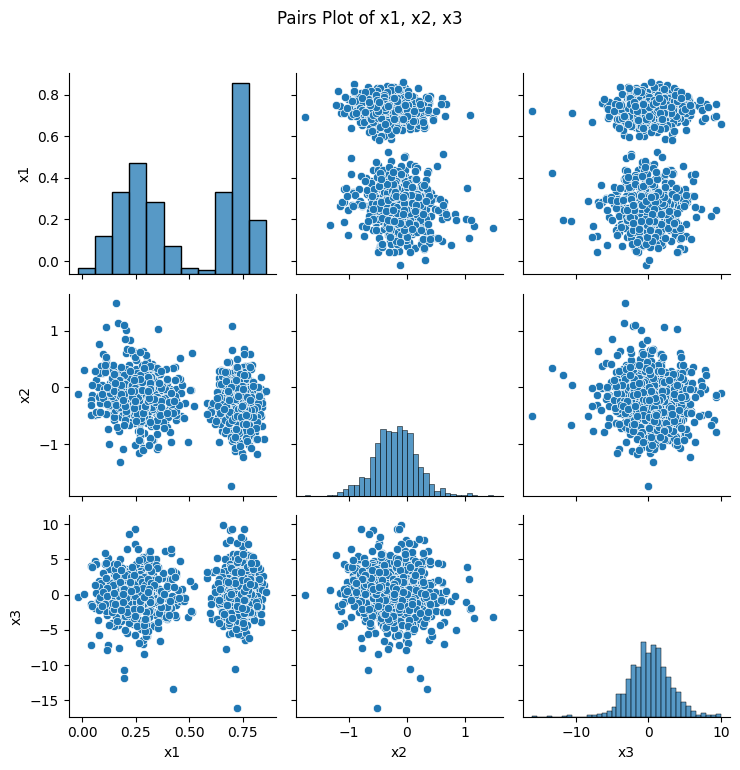

In [2]:
def f(x):
    # Assuming f is defined as tanh(x) based on typical synthetic data examples
    return -0.3 * x

def dgp(n_obs,f, doX=[None, None, None], seed=-1):
    if seed > 0:
        np.random.seed(seed)
        print(f"Setting Seed: {seed}")

    # X_1
    if doX[0] is None:
        X_1_A = np.random.normal(0.25, 0.1, n_obs)
        X_1_B = np.random.normal(0.73, 0.05, n_obs)
        choice = np.random.choice([0, 1], size=n_obs)
        X_1 = np.where(choice == 0, X_1_A, X_1_B)
    else:
        X_1 = np.full(n_obs, doX[0])

    # X_2
    if doX[1] is None:
        U2 = np.random.uniform(size=n_obs)
        x_2_dash = np.log(U2 / (1 - U2))
        X_2 = (x_2_dash - 2 * X_1) / 5.0
    else:
        X_2 = np.full(n_obs, doX[1])

    # X_3
    if doX[2] is None:
        U3 = np.random.uniform(size=n_obs)
        x_3_dash = np.log(U3 / (1 - U3))
        X_3 = (x_3_dash + 0.2 * X_1 + f(X_2)) / 0.63
    else:
        X_3 = np.full(n_obs, doX[2])

    # Adjacency matrix
    A = np.array([[0, 1, 1],
                  [0, 0, 1],
                  [0, 0, 0]])

    # Create DataFrame
    df_R = pd.DataFrame({
        'x1': X_1,
        'x2': X_2,
        'x3': X_3
    })

    df_orig = torch.tensor(df_R.values, dtype=torch.float32)

    # 5% and 95% quantiles
    q1 = np.quantile(X_1, [0.05, 0.95])
    q2 = np.quantile(X_2, [0.05, 0.95])
    q3 = np.quantile(X_3, [0.05, 0.95])

    min_vals = torch.tensor([q1[0], q2[0], q3[0]], dtype=torch.float32)
    max_vals = torch.tensor([q1[1], q2[1], q3[1]], dtype=torch.float32)

    return {
        'df_orig': df_R,
        'df_torch': df_orig,
        'min': min_vals,
        'max': max_vals,
        'type': ['c', 'c', 'c'],
        'A': A
    }





out = dgp(1000, f=f,doX=[None, None, None],seed=42)
print(out['df_orig'].head())
df=out['df_orig']
# Create pairs plot
sns.pairplot(out['df_orig'])
plt.suptitle("Pairs Plot of x1, x2, x3", y=1.02)
plt.tight_layout()
plt.show()

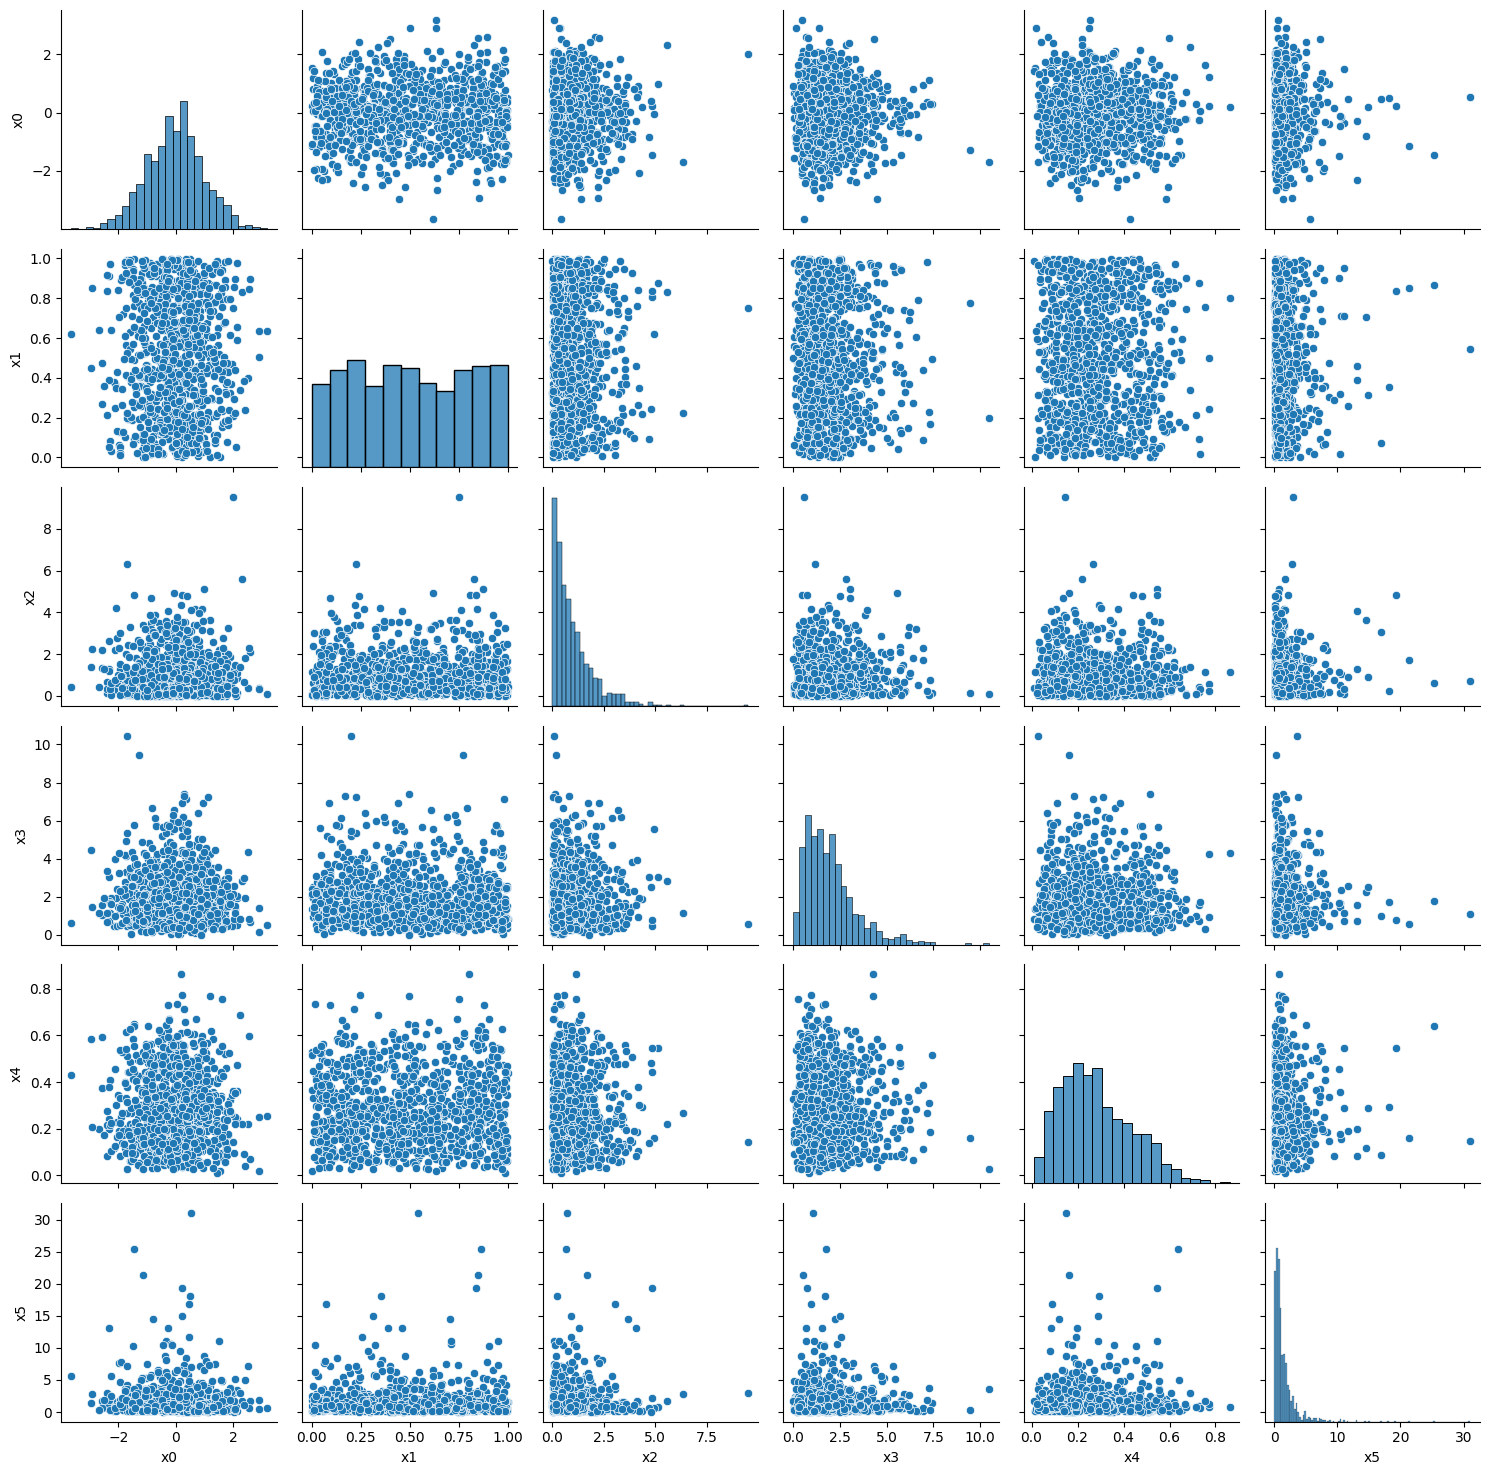

In [3]:

# Config
n_samples = 1000
n_features = 6
rng = np.random.default_rng(seed=42)

# Define different distributions
distributions = [
    lambda n: rng.normal(loc=0, scale=1, size=n),         # standard normal
    lambda n: rng.uniform(low=0, high=1, size=n),          # uniform [0,1]
    lambda n: rng.exponential(scale=1.0, size=n),          # exponential
    lambda n: rng.gamma(shape=2.0, scale=1.0, size=n),     # gamma
    lambda n: rng.beta(a=2.0, b=5.0, size=n),              # beta
    lambda n: rng.lognormal(mean=0.0, sigma=1.0, size=n),  # log-normal
    lambda n: rng.chisquare(df=2, size=n),                 # chi-squared
    lambda n: rng.triangular(left=0.0, mode=0.5, right=1.0, size=n), # triangular
    lambda n: rng.weibull(a=2.0, size=n),                  # weibull
    lambda n: rng.pareto(a=2.5, size=n),                   # pareto
]

# Create features
X = np.column_stack([dist(n_samples) for dist in distributions[:n_features]])

# Wrap in DataFrame
feature_names = [f'x{i}' for i in range(n_features)]
df = pd.DataFrame(X, columns=feature_names)

sns.pairplot(df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [4]:
DATA_PATH = "/home/bule/TramDag/data"
WEIGHTS_DIR="/home/bule/TramDag/weights"

### train test split

In [5]:
# train
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
# Validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 800, Validation size: 100, Test size: 100


# Define graph Structure

- define graph and which shift and intercept terms to use


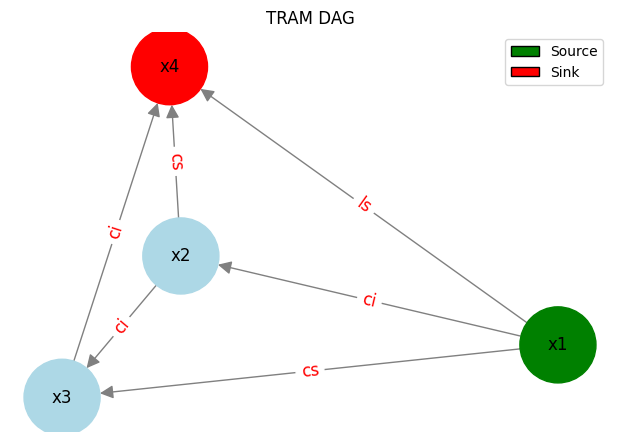

In [6]:
# describe if data is continous or  ordinal  ['cont', 'ord','other']
# note that other data than tabular can only be used as source 

# TODO support for interactions in CI model eg CI_1

# # Example 1 dgp tramdag paper  3x3: 
# data_type={'x1':'cont','x2':'cont','x3':'cont'}  # continous , images , ordinal
# adj_matrix = np.array([
#     [ "0", "ci", "ci"],  # A -> B (cs), A -> C (ls)
#     [ "0", "0", "cs"],  # B -> D (ls)
#     [ "0", "0", "0"],  # C -> D (cs)
# ], object)
# seed=5


# its also possible to have ci11 and ci12 etc to inlcude multiple varibales for a network for the intercept. aswell as for cs name it with ci11 ci12


# Example 1 dgp tramdag paper  3x3: 
data_type={'x1':'cont','x2':'cont','x3':'cont','x4':'cont'}  # continous , images , ordinal
adj_matrix = np.array([
    [ "0", "ci", "cs", "ls"],  # A -> B (cs), A -> C (ls)
    [ "0", "0",  "ci", "cs"],  # B -> D (ls)
    [ "0", "0",  "0" , "ci" ],
    [ "0", "0",  "0" , "0" ],# C -> D (cs)
], object)
seed=10

#TODO solve inf problem for x4 model prob due to x1 

# # example 2 6x6
# data_type={'x0':'cont','x1':'cont','x2':'cont','x3':'cont','x4':'cont','x5':'cont'}  # images, continous, continous, continous    
# adj_matrix = np.array([
#                                 ["0", "0", "0", "0", "ci", "ci"],  # A -> B (cs), A -> C (ls)
#                                 ["0", "0", "0"  , "0", "ci", "ci"],  # B -> D (ls)
#                                 ["0", "0", "0"  , "0", "0", "ci"],  # C -> D (cs)
#                                 ["0", "0", "0"  , "0", "0", "ci"],  # C -> D (cs)
#                                 ["0", "0", "0"  , "0" , "0", "ci"],
#                                 ["0", "0", "0"  , "0" , "0", "0"] # No outgoing edges from D
#                             ], dtype=object)


plot_dag(adj_matrix,data_type, seed=seed)

# Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

************* 
 Model has Complex intercepts and Coomplex shifts , please add your Model to the modelzoo 
************


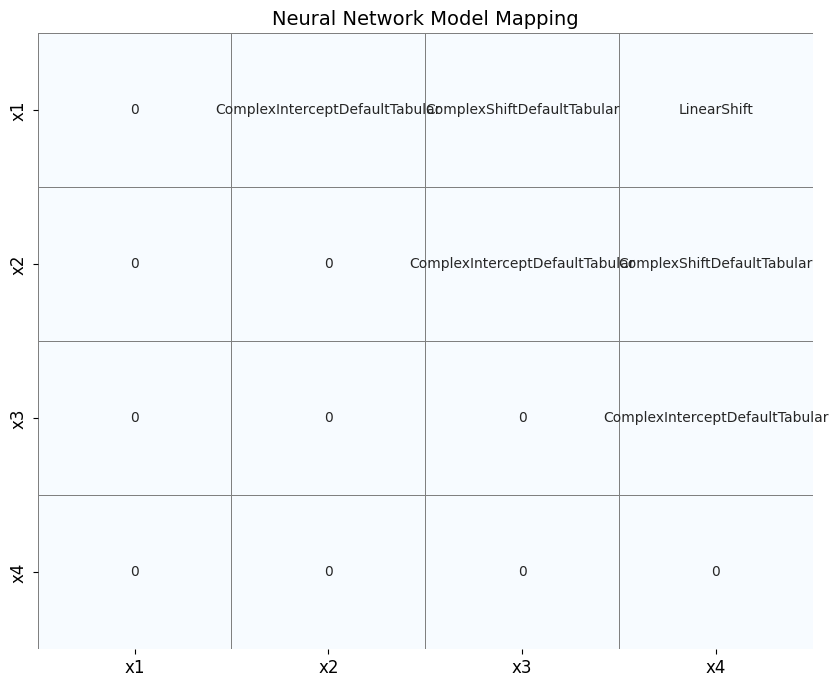

In [7]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
plot_nn_names_matrix(nn_names_matrix,data_type)

- add custom models for the ci or cs

In [8]:
df

,x0,x1,x2,x3,x4,x5
0,0.304717,0.647072,0.290968,1.347024,0.208999,1.622456
1,-1.039984,0.342362,1.646044,0.196559,0.290034,0.529964
2,0.750451,0.408157,0.023771,1.341390,0.507324,0.079368
3,0.940565,0.440050,1.741424,6.946277,0.111053,0.185544
4,-1.951035,0.125807,1.304794,1.179941,0.084003,4.734432
...,...,...,...,...,...,...
995,0.352720,0.021831,0.042685,2.222494,0.252631,2.457448
996,0.766823,0.515133,1.111937,1.106235,0.427482,0.229404
997,0.121178,0.344831,0.870796,0.354832,0.463161,0.751790
998,0.130764,0.421280,0.395657,1.039549,0.467491,2.291378


In [9]:
# TODO: fucniton to automate
# if different models should be used, defin model in utils.models 
# e.g ComplexInterceptCUSTOMImage # any possible eg VITS

# rename the modelnames in the nn_names_matrix
# e.g.nn_names_matrix[2,3]='ComplexInterceptCUSTOMImage'  

- model configurations

In [10]:
#TODO : OPTION write config to a argparser to  and args object to pass datatypes


conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
conf_dict

{'x1': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {}},
 'x2': {'Modelnr': 1,
  'data_type': 'cont',
  'node_type': 'internal',
  'parents': ['x1'],
  'parents_datatype': {'x1': 'cont'},
  'transformation_terms_in_h()': {'x1': 'ci'},
  'transformation_term_nn_models_in_h()': {'x1': 'ComplexInterceptDefaultTabular'}},
 'x3': {'Modelnr': 2,
  'data_type': 'cont',
  'node_type': 'internal',
  'parents': ['x1', 'x2'],
  'parents_datatype': {'x1': 'cont', 'x2': 'cont'},
  'transformation_terms_in_h()': {'x1': 'cs', 'x2': 'ci'},
  'transformation_term_nn_models_in_h()': {'x1': 'ComplexShiftDefaultTabular',
   'x2': 'ComplexInterceptDefaultTabular'}},
 'x4': {'Modelnr': 3,
  'data_type': 'cont',
  'node_type': 'sink',
  'parents': ['x1', 'x2', 'x3'],
  'parents_datatype': {'x1': 'cont', 'x2': 'cont', 'x3': 'cont'},
  'transformation_terms_in_h()': {'x1':

## Fit models

- each model independently fitting

In [11]:
from utils.tram_models import *
from utils.tram_model_utils import *

from utils.tram_data import *
from torchvision import transforms
from utils.loss_ordinal import *
from utils.loss_continous import *

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")


Train with GPU support.


In [12]:
DEV_TRAINING=True

In [13]:
batch_size = 512

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")


# For each NODE 
for node in conf_dict:
    print(f'\n----------node: {node}--------')

        
    # TODO add args to the models via config file eg nn_int = globals()[nn_int_name](args) , args from conf
    
    # image models are not supported yet
    if (conf_dict[node]['node_type'] == 'source') and (conf_dict[node]['node_type'] == 'other'):
        continue

    ######################################################## 1. Create tram Model ######################
    
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=True)
    tram_model = tram_model.to(device)

    ##################################################### 2. Create Dataloaders ######################
    
    train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=32,verbose=True)
    
    ##################################################### 3. Train Model #####################
    
    
    optimizer = None
    use_scheduler = True
    epochs = 500

    best_val_loss = float('inf')
    train_loss_hist = []
    val_loss_hist = []

    if optimizer is None:
        optimizer = torch.optim.Adam(tram_model.parameters(), lr=0.001, eps=1e-7, weight_decay=0.0)
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

    # MIN MAX 5 / 95 q from training data
    min_max = torch.Tensor([out['min'][0], out['max'][1]]).to(device)
    
    
    if DEV_TRAINING:

        for epoch in range(epochs):
            
            ##### TRAINING
            train_loss = 0.0
            tram_model.train()

            if use_scheduler:
                scheduler.step()

            for x, y in train_loader:
                x = [xi.to(device) for xi in x] # data ordered as in ordered_parents() 
                y = y.to(device)
                optimizer.zero_grad()
                y_pred = tram_model(int_input=x[0].unsqueeze(1))  # turns (B,) into (B,1)
                loss = contram_nll(y_pred, y, min_max=min_max)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            avg_train_loss = train_loss / len(train_loader)
            train_loss_hist.append(avg_train_loss)

            ######## VALIDATION
            val_loss = 0.0
            tram_model.eval()
            with torch.no_grad():
                for x, y in val_loader:
                    x = [xi.to(device) for xi in x]
                    y = y.to(device)
                    y_pred = tram_model(int_input=x[0].unsqueeze(1))
                    loss = contram_nll(y_pred, y, min_max=min_max)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            val_loss_hist.append(avg_val_loss)
            
            
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                
                os.makedirs(os.path.join(WEIGHTS_DIR,f'{node}'), exist_ok=True)
                torch.save(tram_model.state_dict(), os.path.join(WEIGHTS_DIR,f'{node}', "best_model.pt"))
                print("Saved new best model.")




Train with GPU support.

----------node: x1--------
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 


/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/500, Train Loss: 0.5359, Val Loss: 0.5328
Saved new best model.
Epoch 2/500, Train Loss: 0.5301, Val Loss: 0.5272
Saved new best model.
Epoch 3/500, Train Loss: 0.5246, Val Loss: 0.5219
Saved new best model.
Epoch 4/500, Train Loss: 0.5196, Val Loss: 0.5170
Saved new best model.
Epoch 5/500, Train Loss: 0.5148, Val Loss: 0.5124
Saved new best model.
Epoch 6/500, Train Loss: 0.5103, Val Loss: 0.5082
Saved new best model.
Epoch 7/500, Train Loss: 0.5062, Val Loss: 0.5041
Saved new best model.
Epoch 8/500, Train Loss: 0.5023, Val Loss: 0.5004
Saved new best model.
Epoch 9/500, Train Loss: 0.4988, Val Loss: 0.4968
Saved new best model.
Epoch 10/500, Train Loss: 0.4953, Val Loss: 0.4938
Saved new best model.
Epoch 11/500, Train Loss: 0.4923, Val Loss: 0.4907
Saved new best model.
Epoch 12/500, Train Loss: 0.4894, Val Loss: 0.4880
Saved new best model.
Epoch 13/500, Train Loss: 0.4868, Val Loss: 0.4855
Saved new best model.
Epoch 14/500, Train Loss: 0.4844, Val Loss: 0.4833
Saved new

(out['min'][0],out['max'][1])

# Sample from target

- sample from logistic